In [ ]:
# pick several groups of token from IMHere and assign each of them an ID
# assign labels to images by loading the labels from a csv file (with each row including ID image_name label)
# display the images with their labels and put images with the same label on the same row

import os
import csv
import cv2
import numpy as np
from pprint import pprint
from collections import namedtuple
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.svm import SVC

try:
    from google.colab import drive
    drive.mount('/content/drive')
    workspace = '/content/drive/MyDrive'
    %pip install -U opencv-python
except:
    workspace = '.'

root = os.path.join(workspace, 'Tutorial-images')
label_path = os.path.join(root, 'label.csv')

# **Image Classification Part-1: Predict the Labels of New Examples**

In Image Clustering, we teach computers to group images by drawing "circles". The process is called unsupervised learning because it's data-driven and without using human "knowledge". However, the resuling clusters may not be consistent with our understanding of the data. 

In this tutorial, we teach computers to draw the "circle" in a supervised way. To this end, we "tell" the computers about our understanding of the data by giving each image a label which indicates which catagory (class) it belongs to.

Let's use the images from IMHere again. A file named label.csv including the image IDs and labels (the students who submitted the images) is prepared for you. We choose the last sample of each catagory as the test sample.

What we have to do is to load the images and labels into the memory.

In [ ]:
## Show the content of the label file "label.csv"

def labels2strs(labels: list) -> list:
    lengths = np.max([[len(j) for j in i] for i in labels], axis=0)
    format_str = ' '.join(['{:^%ds}'%length for length in lengths])
    seps = ' '.join(['-'*length for length in lengths])
    contents = [format_str.format(*row) for row in labels]
    contents.insert(1, seps)
    return contents

if os.path.exists(label_path):
    with open(label_path) as f:
        flabels = list(csv.reader(f))
    print(*labels2strs(flabels), sep='\n')
else:
    raise ValueError('Invalid label file path [%s]'%label_path)

ID filename label split
-- -------- ----- -----
0   1.jpg     0   train
1   2.jpg     1   train
2   3.jpg     1   train
3   4.jpg     1    val 
4   5.jpg     2   train
5   6.jpg     3   train
6   7.jpg     3   train
7   8.jpg     2   train
8   9.jpg     0   train
9   10.jpg    2    val 
10  11.jpg    0    val 
11  12.jpg    3    val 


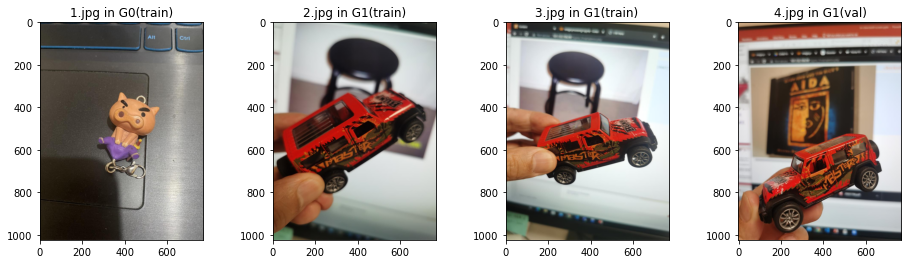

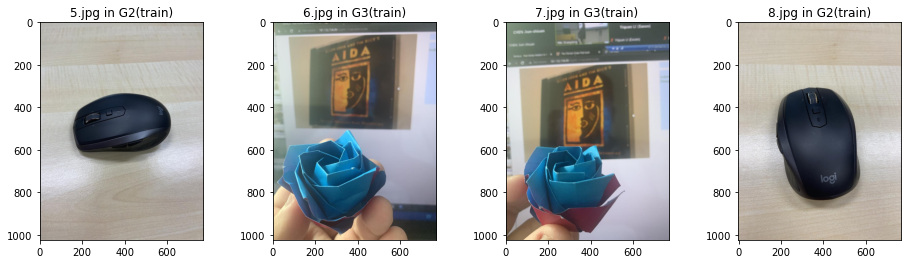

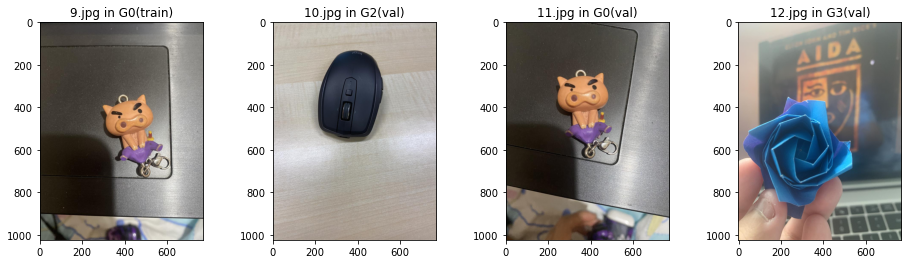

In [ ]:
## display the images and their labels

samples = {'train': [], 'val': []}

class Sample:
    def __init__(self, idx=0, fname='', img=None, feat=None, label=None):
        self.idx = idx
        self.fname = fname
        self.img = img
        self.feat = feat
        self.label = label
        self.pred = None

for idx, fname, label, split in flabels[1:]:
    idx, label = int(idx), int(label)
    if idx % 4 == 0:
        plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, idx%4+1)
    plt.title(f'{fname} in G{label}({split})')

    fpath = os.path.join(root, fname)
    if not os.path.isfile(fpath):
        raise ValueError('%s not found' % fpath)
    else:
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)[..., ::-1]
        H, W, C = img.shape
        
        plt.imshow(img)
        
        samples[split].append(Sample(idx, fname, img, None, label))

As you see, each image is associated with a label. Now we have to convert images into "numbers" so that computers can play with. We use the hog features which we developed in the last tutorial.

In [ ]:
## extract features

sift = cv2.SIFT_create()

def get_feat(img):
    return hog(img)
#     return sift_feat(img)
#     return gray_histogram(img)

def calc_distance(x, y):
    return L2_distance(x, y)
#     return L2_distance_sift(x, y)


def sift_feat(img):
    kps, des =  sift.detectAndCompute(img, None)
    responses = [kp.response for kp in kps]
    order = np.argsort(responses)[::-1]
    return np.array(des[order[:30]])

def gray_histogram(img: np.array, norm: bool = True) -> np.array:
    if img.shape[-1] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hist = np.array([len(img[img == i]) for i in range(256)])
    if norm:
        return hist / np.size(img)
    return hist

def L2_distance(x, y):
    return ((x - y) ** 2).sum() ** 0.5

def L2_distance_sift(x, y):
    dist = ((x[:, None] - y[None, :])**2).sum(axis=-1).min(axis=-1)
    dist.sort()
    return dist[:15].mean()


for sample in samples['train']:
    sample.feat = get_feat(sample.img)

for sample in samples['val']:
    sample.feat = get_feat(sample.img)


As mentioned, it's important to think in the feature space. Let's visualize what these images look like there.

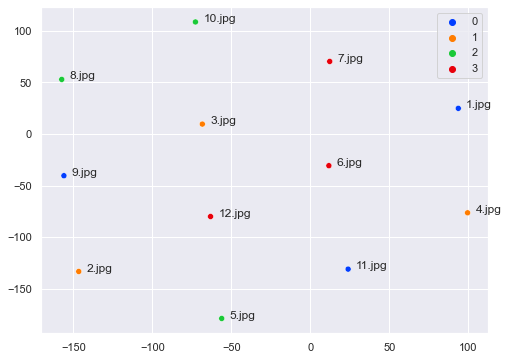

In [ ]:
## visualize images in feature space using t-SNE with IDs and Labels for image

sns.set(rc={'figure.figsize':(8,6)})
palette = sns.color_palette("bright", 4)

features = [sample.feat for sample in (samples['train'] + samples['val'])]
labels = [sample.label for sample in (samples['train'] + samples['val'])]
ids = [sample.fname for sample in (samples['train'] + samples['val'])]

tsne = TSNE()
X_embedded = tsne.fit_transform(features)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette)
for i, (x, y) in enumerate(X_embedded):
    plt.text(x+5, y, ids[i])

# **1. kNN Classifers**

kNN might be the simplest classifers. Given an image X to be classified, kNN searches over the feature space for X's k nearest neighbours (NNs) and assigns the dominating label among thoese NNs to X. As we have introduced the image retrieval, it's easy to find the NNs using the algorithm we developed. In this case, we can consider kNN as a classify-by-retrieval paradigm.

4.jpg with label 1 is predicted as 3
10.jpg with label 2 is predicted as 2
11.jpg with label 0 is predicted as 0
12.jpg with label 3 is predicted as 2


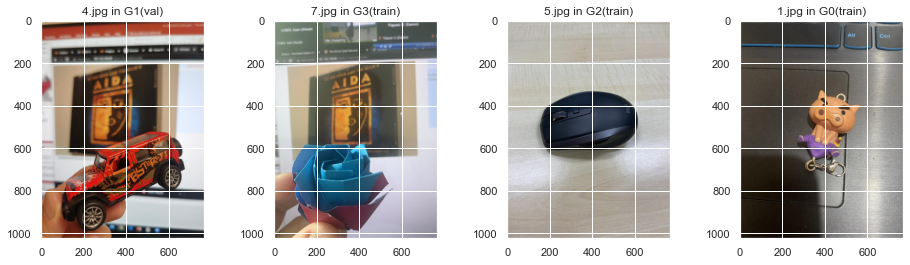

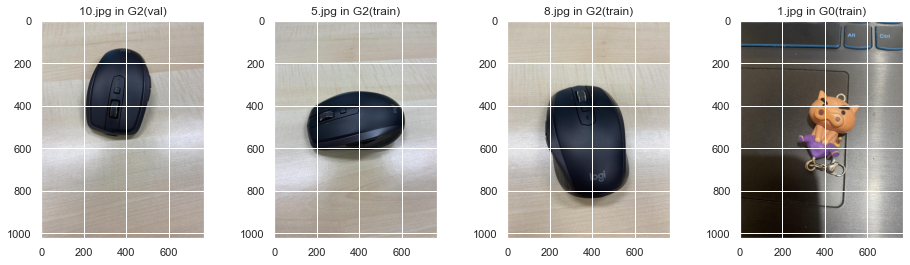

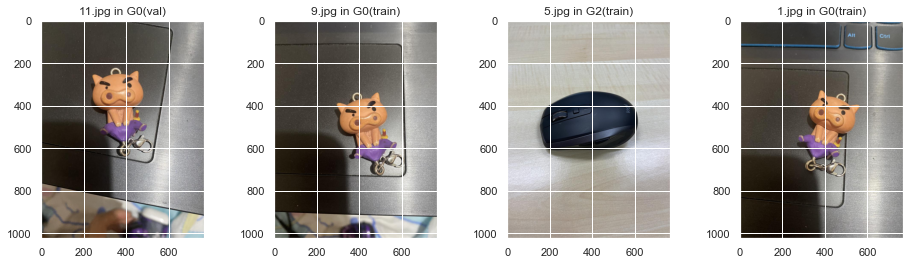

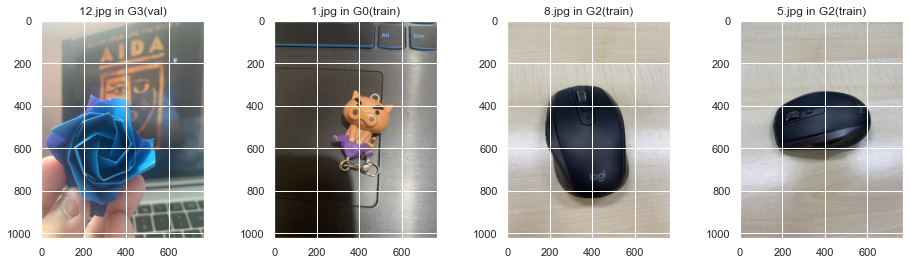

In [ ]:
# for each image in the testing list, search its NNs
# display in each row the target image X to classify, the NNs, label assigned to X, and the ground truth label

def kNN(test_sample, train_samples, k=3):
    distances = []
    for sample in train_samples:
        distance = calc_distance(test_sample.feat, sample.feat)
        distances.append((distance, sample))
    distances = sorted(distances, key=lambda x: x[0])[:k]
    label_count = {}
    plt.figure(figsize=((k+1)*4, 4))
    plt.subplot(1, k+1, 1)
    plt.title(f'{test_sample.fname} in G{test_sample.label}(val)')
    plt.imshow(test_sample.img)
    for i, (distance, sample) in enumerate(distances):
        plt.subplot(1, k+1, i+2)
        plt.title(f'{sample.fname} in G{sample.label}(train)')
        plt.imshow(sample.img)
        label_count[sample.label] = label_count.get(sample.label, 0) + 1
    max_label, max_count = -1, 0
    for label, count in label_count.items():
        if count > max_count:
            max_label, max_count = label, count
    test_sample.pred = max_label

for sample in samples['val']:
    kNN(sample, samples['train'])
    print(sample.fname, 'with label', sample.label, 'is predicted as', sample.pred)

It works well for some of the images (2 out of 4), but fails for others (2 out of 4). It's not superising becasue we don't really have a model for classification. Let's try SVM which trains an acutal model.



# **2. SVM (Support Vector Machines)** 

SVM classifies by finding a hyper plane to separate the classes. The plane is with the maximun "margins" to each of the classes. SVM is much more complicated than kNN. Luckily, it's already built in sklearn. Let's import the libary and run SVM.

In [ ]:
# train with SVM
model = SVC(kernel='rbf')

train_samples = [sample.feat for sample in samples['train']]
train_labels = [sample.label for sample in samples['train']]
model.fit(train_samples, train_labels)

# test with SVM
test_samples = [sample.feat for sample in samples['val']]
results = model.predict(test_samples)
for sample, result in zip(samples['val'], results):
    sample.pred = result
    print(sample.fname, 'with label', sample.label, 'is predicted as', sample.pred)
# display the results (target images with the predicted labels and ground truth label)

4.jpg with label 1 is predicted as 3
10.jpg with label 2 is predicted as 2
11.jpg with label 0 is predicted as 0
12.jpg with label 3 is predicted as 3


See, it's getting better. Now, 3 out of 4 images have been classified correctly.